In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd

from scipy.optimize import minimize
import scipy.io

from sklearn.decomposition import randomized_svd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import h5py
from scipy import interpolate
from scipy import stats
from scipy import signal

import glob
import pickle

from chirpMB import *

%load_ext autoreload
%autoreload 2

## Load stimulus

### Chirp (full field)

In [2]:
#load data
data_name = "/gpfs01/euler/data/"+"User/yqiu/BadenEtAl_RGCs_2016_v1.mat"
rgcdata=scipy.io.loadmat(data_name)
print (rgcdata.keys())

dict_keys(['__header__', '__version__', '__globals__', 'ans', 'noise_time', 'noise_trace', 'noise_stim', 'cluster_idx', 'group_idx', 'c2g', 'sel_idx', 'cell_dsi', 'cell_dp', 'cell_osi', 'cell_op', 'cell_area', 'cell_volume', 'cell_id', 'cell_oo_idx', 'cell_ff_idx', 'chirp_avg', 'chirp_byrepeat', 'chirp_time', 'chirp_stim', 'chirp_stim_time', 'chirp_qi', 'chirp_scaling', 'bar_byrepeat', 'bar_tc', 'bar_qi', 'bar_time', 'rf_tc', 'rf_time', 'rf_qi', 'rf_size', 'rf_map', 'rf_gauss_mean', 'rf_gauss_std', 'color_avg', 'color_byrepeat', 'color_time', 'color_qi', 'immuno_gad', 'immuno_chat', 'immuno_smi', 'immuno_melanopsin', 'genetics_pv', 'genetics_pcp', 'structural', 'rois', 'offsets'])


(31988,) (31988,)
duration: 32.0 s
data frequency: 999.625 Hz
(3199,)


Text(0, 0.5, 'a.u.')

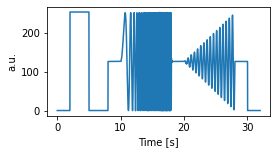

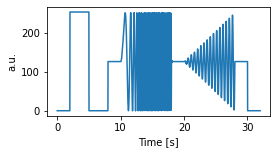

In [3]:
chirp_stim      = rgcdata['chirp_stim'].flatten() # Stimulus waveform of chirp
chirp_stim_time = rgcdata['chirp_stim_time'].flatten() # Time base for stimulus waveform
print (chirp_stim.shape, chirp_stim_time.shape)
print ('duration: {0} s'.format(chirp_stim_time[-1]))
print ('data frequency: {0} Hz'.format(len(chirp_stim_time)/chirp_stim_time[-1]))
fig,axes=plt.subplots(figsize=(4,2))
axes.plot(chirp_stim_time,chirp_stim)
axes.set_xlabel('Time [s]')
axes.set_ylabel('a.u.')
#
fre_chirp=100
scale=int(np.round(len(chirp_stim_time)/chirp_stim_time[-1] /fre_chirp))
chirp_stim=chirp_stim[::scale]
chirp_stim_time=chirp_stim_time[::scale]
print (chirp_stim.shape)
fig,axes=plt.subplots(figsize=(4,2))
axes.plot(chirp_stim_time,chirp_stim)
axes.set_xlabel('Time [s]')
axes.set_ylabel('a.u.')

## Data

In [4]:
def pro_chirp(filepath):
    data = load_h5_data(filepath)
    roi_ids = np.arange(data['Traces0_raw'].shape[1]) # roi_id_temp[filepath[:-9]]
    chirps=[]
    for ii in range(len(roi_ids)):
        roi_id = roi_ids[ii]
        traces_raw = data['Traces0_raw'][:, roi_id]
        tracetime = data['Tracetimes0'][:, roi_id]
        triggertime = data['Triggertimes']
        chirp = Chirp(traces_raw, tracetime, triggertime)
        chirp.get_trace()
        chirps.append(chirp.traces)
    chirps = np.array(chirps)
    return chirps

def pro_MB(filepath):
    data = load_h5_data(filepath)
    roi_ids = np.arange(data['Traces0_raw'].shape[1])#roi_id_temp[filepath[:-6]]
    MBs  = []
    for ii in range(len(roi_ids)):
        roi_id = roi_ids[ii]
        traces_raw = data['Traces0_raw'][:, roi_id]
        tracetime = data['Tracetimes0'][:, roi_id]
        triggertime = data['Triggertimes']
        mb = MovingBar(traces_raw, tracetime, triggertime)
        mb.get_trace()
        MBs.append(mb.traces)
    MBs = np.array(MBs)
    return MBs

In [5]:
folders = ["/gpfs01/euler/data/"+"Data/Debinski/best_data_shorter_path/20210804/", ]
data_dict = dict()
for folder in folders:
    filepaths = glob.glob(folder+'*.h5')
    for filepath in filepaths:
        if 'chirp' in filepath:
            data_dict.update({filepath: pro_chirp(filepath)})
        elif 'MB' in filepath:
            data_dict.update({filepath: pro_MB(filepath)})


In [6]:
def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#save_obj(data_dict, 'out/diff_inten.pkl')

## Load preprocessed data

In [7]:
def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [18]:
temp_dict = load_obj('out/diff_inten.pkl')
keys = temp_dict.keys()
keys_list = [key for key in keys]
#print (keys_list)
#for key in keys:
#    print (temp_dict[key].shape)
print (temp_dict[keys_list[0]].shape, temp_dict[keys_list[1]].shape)

(87, 5, 249) (87, 3, 8, 32)


## Chirp

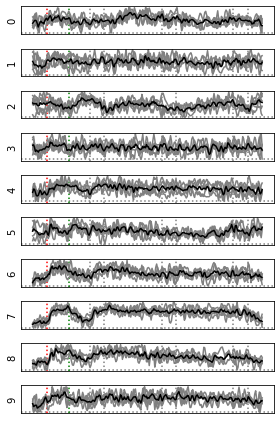

In [16]:
data = temp_dict[keys_list[5]]
ncols = 10 #len(data)

fig,axes=plt.subplots(nrows=ncols, ncols=1, figsize=(4,int(ncols/1.5)))
col_ind = 0 # column index
for ii in range(ncols):
    axes[col_ind].axhline(y=0,color='gray',linestyle=':')
    axes[col_ind].axvline(x=2,color='r',linestyle=':')
    axes[col_ind].axvline(x=5,color='g',linestyle=':')
    for jj in range(3):
        axes[col_ind].axvline(x=8+jj*10,color='gray',linestyle=':')
        axes[col_ind].axvline(x=10+jj*10,color='gray',linestyle=':')
    for jj in range(5):
        axes[col_ind].plot(np.linspace(0, 32, 249), data[ii,jj],color='gray')
    axes[col_ind].plot(np.linspace(0, 32, 249), data[ii].mean(axis=0),color='k')
    axes[col_ind].set_xticks([])
    axes[col_ind].set_yticks([])
    axes[col_ind].set_ylabel('{0}'.format(col_ind))
    #
    col_ind = col_ind+1
plt.tight_layout()

## MB

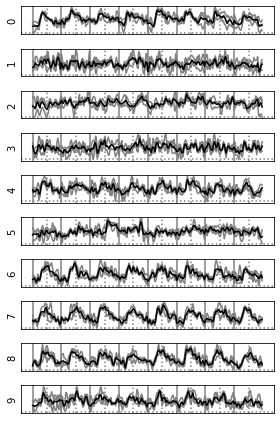

In [17]:
data = temp_dict[keys_list[6]]
#sorted directions
dir_deg = [0,180, 45,225, 90,270, 135,315]
sorting = np.argsort(dir_deg)
data = data[:,:,sorting,:]
ncols = 10 # len(data)

fig,axes=plt.subplots(nrows=ncols, ncols=1, figsize=(4,int(ncols/1.5)))
col_ind = 0 # column index
for ii in range(ncols):
    for jj in range(8):
        axes[col_ind].axvline(x=4*jj,color='gray')
        axes[col_ind].axvline(x=4*jj+2,color='gray',linestyle=':')
    axes[col_ind].axhline(y=0,color='gray',linestyle=':')
    for jj in range(3):
        axes[col_ind].plot(np.arange(8*4*8)/8, data[ii,jj].flatten(),color='gray')
    axes[col_ind].plot(np.arange(8*4*8)/8, data[ii].mean(0).flatten(),color='k')
    axes[col_ind].set_xticks([])
    axes[col_ind].set_yticks([])
    axes[col_ind].set_ylabel('{0}'.format(col_ind))
    #
    col_ind = col_ind+1
plt.tight_layout()

## Quality index

In [11]:
def qi(responses):
    """
    Get the quality index of responses
    responses shape: (repeat, time)
    """
    return np.var(np.mean(responses,axis=0))/np.mean(np.var(responses,axis=1))

In [12]:
#MB
data = temp_dict[keys_list[6]]
# example neuron
eg_data = data[0]
print (qi(eg_data.reshape(3,256)))

0.6688115718350937


In [13]:
#chirp
data = temp_dict[keys_list[5]]
# example neuron
eg_data = data[0]
print (qi(eg_data.reshape(5,249)))

0.3605098259007885


## Polar plot of MB

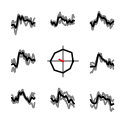

In [14]:
data = temp_dict[keys_list[6]]
#sorted directions
dir_deg = [0,180, 45,225, 90,270, 135,315]
sorting = np.argsort(dir_deg)
data = data[:,:,sorting,:]
# example neuron
eg_data = data[0]
osds = OsDsIndexes(np.transpose(eg_data,axes=(2,1,0)),dir_deg = [0, 45, 90, 135, 180, 225, 270,315]) 
osds.OsDs()
osds.plot_MB(figsize=(2,2),figname="out/MB.svg",saveflag=False) # save figure when setting flag=True